# Imports

In [28]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD, Adam

from keras.engine.training import Model
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

#from keras import layers
#import keras.callbacks as kcb

In [2]:
!unzip '/content/drive/MyDrive/deep_learning/bird_CUB_200_2011.zip'

Streaming output truncated to the last 5000 lines.
  inflating: CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0067_112913.jpg  
  inflating: CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg  
  inflating: CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0073_112745.jpg  
  inflating: CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0074_111997.jpg  
  inflating: CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg  
  inflating: CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0080_111099.jpg  
  inflating: CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0082_112478.jpg  
  inflating: CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0083_111470.jpg  
  inflating: CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0084_111300.jpg  
  inflating: CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0086_111385.jpg  
  inflating: CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0092_111413.jpg  
  inflating: CUB_200_2011/images/118

# Read TextFiles to Pandas dataframe

In [3]:
base_path = '/content/CUB_200_2011'
#bounding_box = pd.read_csv((base_path+"/bounding_boxes.txt"), sep=" ", names=["frame_id", "a", "b", "c", "d"], index_col="frame_id")
classes_table            = pd.read_csv((base_path+"/classes.txt"), sep=" ", names=["class_id", "class_name"],index_col="class_id")
classes            = list(classes_table["class_name"])

images             = pd.read_csv(base_path+"/images.txt", sep=" ", names=["image_id", "image_path"],index_col="image_id")
image_class_labels = pd.read_csv(base_path+"/image_class_labels.txt", sep=" ", names=["image_id", "class_id"],index_col="image_id")

train_test         = pd.read_csv(base_path+"/train_test_split.txt", sep=" ", names=["image_id", "is_train"], index_col="image_id").applymap(bool)


In [4]:
images['image_path']

image_id
1        001.Black_footed_Albatross/Black_Footed_Albatr...
2        001.Black_footed_Albatross/Black_Footed_Albatr...
3        001.Black_footed_Albatross/Black_Footed_Albatr...
4        001.Black_footed_Albatross/Black_Footed_Albatr...
5        001.Black_footed_Albatross/Black_Footed_Albatr...
                               ...                        
11784    200.Common_Yellowthroat/Common_Yellowthroat_00...
11785    200.Common_Yellowthroat/Common_Yellowthroat_00...
11786    200.Common_Yellowthroat/Common_Yellowthroat_00...
11787    200.Common_Yellowthroat/Common_Yellowthroat_00...
11788    200.Common_Yellowthroat/Common_Yellowthroat_00...
Name: image_path, Length: 11788, dtype: object

# Preprocess data

In [5]:
orig_img_size = (299,299) #(299,299)(224,224)
batch_size = 32

In [6]:
temp_df = [images, image_class_labels, train_test]

In [7]:
import functools as ft
image_metadata = ft.reduce(lambda left, right: pd.merge(left, right, on='image_id'), temp_df)

In [8]:
image_metadata = pd.merge(image_metadata, classes_table, on = 'class_id', how = 'left')

In [9]:
image_metadata = image_metadata.sample(frac=1).reset_index(drop=True)
image_metadata

,image_path,class_id,is_train,class_name
0,042.Vermilion_Flycatcher/Vermilion_Flycatcher_...,42,False,042.Vermilion_Flycatcher
1,084.Red_legged_Kittiwake/Red_Legged_Kittiwake_...,84,True,084.Red_legged_Kittiwake
2,143.Caspian_Tern/Caspian_Tern_0015_145664.jpg,143,True,143.Caspian_Tern
3,138.Tree_Swallow/Tree_Swallow_0098_134916.jpg,138,False,138.Tree_Swallow
4,199.Winter_Wren/Winter_Wren_0077_190366.jpg,199,True,199.Winter_Wren
...,...,...,...,...
11783,182.Yellow_Warbler/Yellow_Warbler_0094_176365.jpg,182,True,182.Yellow_Warbler
11784,010.Red_winged_Blackbird/Red_Winged_Blackbird_...,10,True,010.Red_winged_Blackbird
11785,193.Bewick_Wren/Bewick_Wren_0127_184756.jpg,193,False,193.Bewick_Wren
11786,017.Cardinal/Cardinal_0022_17233.jpg,17,False,017.Cardinal


In [10]:

train_ds = image_metadata.loc[image_metadata['is_train'] == True]
test_ds = image_metadata.loc[image_metadata['is_train'] == False]


#train_ds.class_id = train_ds.class_id.astype(str)
#test_ds.class_id = test_ds.class_id.astype(str)

In [11]:
train_ds

,image_path,class_id,is_train,class_name
1,084.Red_legged_Kittiwake/Red_Legged_Kittiwake_...,84,True,084.Red_legged_Kittiwake
2,143.Caspian_Tern/Caspian_Tern_0015_145664.jpg,143,True,143.Caspian_Tern
4,199.Winter_Wren/Winter_Wren_0077_190366.jpg,199,True,199.Winter_Wren
6,115.Brewer_Sparrow/Brewer_Sparrow_0066_107510.jpg,115,True,115.Brewer_Sparrow
9,166.Golden_winged_Warbler/Golden_Winged_Warble...,166,True,166.Golden_winged_Warbler
...,...,...,...,...
11781,132.White_crowned_Sparrow/White_Crowned_Sparro...,132,True,132.White_crowned_Sparrow
11782,136.Barn_Swallow/Barn_Swallow_0002_130551.jpg,136,True,136.Barn_Swallow
11783,182.Yellow_Warbler/Yellow_Warbler_0094_176365.jpg,182,True,182.Yellow_Warbler
11784,010.Red_winged_Blackbird/Red_Winged_Blackbird_...,10,True,010.Red_winged_Blackbird


In [12]:
test_ds

,image_path,class_id,is_train,class_name
0,042.Vermilion_Flycatcher/Vermilion_Flycatcher_...,42,False,042.Vermilion_Flycatcher
3,138.Tree_Swallow/Tree_Swallow_0098_134916.jpg,138,False,138.Tree_Swallow
5,006.Least_Auklet/Least_Auklet_0041_795107.jpg,6,False,006.Least_Auklet
7,173.Orange_crowned_Warbler/Orange_Crowned_Warb...,173,False,173.Orange_crowned_Warbler
8,147.Least_Tern/Least_Tern_0098_153820.jpg,147,False,147.Least_Tern
...,...,...,...,...
11777,103.Sayornis/Sayornis_0125_98528.jpg,103,False,103.Sayornis
11779,144.Common_Tern/Common_Tern_0037_148048.jpg,144,False,144.Common_Tern
11780,173.Orange_crowned_Warbler/Orange_Crowned_Warb...,173,False,173.Orange_crowned_Warbler
11785,193.Bewick_Wren/Bewick_Wren_0127_184756.jpg,193,False,193.Bewick_Wren


In [13]:
from keras.preprocessing.image import ImageDataGenerator

In [14]:
train_datagenerator = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  zoom_range=0.2,
                                  rotation_range = 25,
                                  validation_split=0.1)#


test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = (train_datagenerator.flow_from_dataframe(
                  dataframe=train_ds,
                  directory='/content/CUB_200_2011/images/',
                  x_col='image_path',
                  y_col='class_name',
                  batch_size=batch_size,
                  seed=42,
                  shuffle=True,
                  class_mode='categorical',
                  color_mode='rgb',
                  subset = 'training',
                  target_size=orig_img_size) )

validation_datagen = (train_datagenerator.flow_from_dataframe(
                  dataframe=train_ds,
                  directory='/content/CUB_200_2011/images/',
                  x_col='image_path',
                  y_col='class_name',
                  batch_size=batch_size,
                  seed=42,
                  shuffle=True,
                  class_mode='categorical',
                  color_mode='rgb',
                  subset = 'validation',
                  target_size=orig_img_size) )

test_datagen = (test_datagen.flow_from_dataframe(
                  dataframe=test_ds,
                  directory='/content/CUB_200_2011/images/',
                  x_col='image_path',
                  y_col='class_name',
                  batch_size=batch_size,
                  seed=42,
                  shuffle=False,
                  class_mode='categorical',
                  color_mode='rgb',
                  target_size=orig_img_size) )

Found 5395 validated image filenames belonging to 200 classes.
Found 599 validated image filenames belonging to 200 classes.
Found 5794 validated image filenames belonging to 200 classes.


In [15]:
x = train_datagen.next()

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


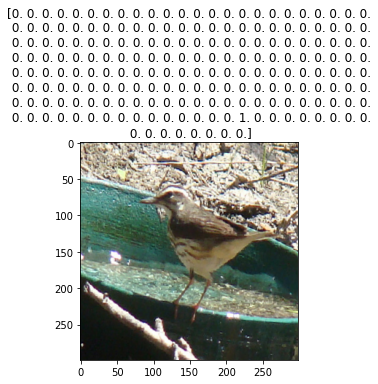

In [16]:
plt.imshow(x[0][1])
plt.title(x[1][1])
plt.clim(0,255)

In [17]:
np.where(x[1][1] == np.amax(x[1][1]))

(array([183]),)

In [18]:
y = list(classes_table.class_name)
y.sort(reverse=False)
print(y)

['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch', '036.Northern_Flicker', '037.Acadian_Flycatcher', '038.Great_Crested_Flycatcher', '039.Least_Flycatcher', '040.Olive_sided_Flycatcher', '041.Scissor_tailed_Flycatcher', '042.Ver

# Xception Final Model

In [19]:
def get_xception_base_model(num_classes,img_size=(299,299,3)):
    
    initial_model: Model = tf.keras.applications.Xception(
                              include_top=False,
                              weights="imagenet",
                              input_shape=img_size,
                              pooling ='avg',
                              classes=200,
                              classifier_activation="softmax",
                          )
    return initial_model

In [20]:
xception_initial_model = get_xception_base_model(len(classes),img_size=(299,299,3))
xception_initial_model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
xception_filepath = '/content/drive/MyDrive/deep_learning/XceptionModelFinal/xception'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}'
xception_checkpoint = tf.keras.callbacks.ModelCheckpoint(xception_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only =False)
#xception_early_stopping = kcb.EarlyStopping(monitor='loss', patience=5)

In [21]:
for layer in xception_initial_model.layers:
  layer.trainable = False
xception_initial_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [22]:
xceptionModel = tf.keras.models.Sequential()
xceptionModel.add(xception_initial_model)
xceptionModel.add(tf.keras.layers.Flatten())
xceptionModel.add(tf.keras.layers.Dense(1024, activation = 'relu'))
xceptionModel.add(tf.keras.layers.Dropout(0.4))
xceptionModel.add(tf.keras.layers.Dense(200, activation='softmax'))

In [ ]:
xceptionModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 200)               205000    
                                                                 
Total params: 23,164,656
Trainable params: 2,303,176
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
opt = SGD(lr=0.01,momentum=0.9) #0.0001 0.0015


def scheduler(epoch, lr):
   if (epoch == 10) | (epoch == 15): #| (epoch == 20)
     return lr * 0.1
   else:
     return lr

callback_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

#opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
xceptionModel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history1 = xceptionModel.fit_generator(train_datagen,epochs = 30, validation_data=validation_datagen, callbacks=[callback_scheduler,xception_checkpoint]) #batch_size=64 validation_split=0.1 callbacks=callbacklist , #history_inception = 

<ipython-input-32-e723a8f994c1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = xceptionModel.fit_generator(train_datagen,epochs = 30, validation_data=validation_datagen, callbacks=[callback_scheduler,xception_checkpoint]) #batch_size=64 validation_split=0.1 callbacks=callbacklist , #history_inception =


Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 4.8892 - acc: 0.0728
Epoch 1: val_acc improved from -inf to 0.14858, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception-saved-model-01-val_acc-0.15


169/169 [==============================] - 157s 863ms/step - loss: 4.8892 - acc: 0.0728 - val_loss: 4.2850 - val_acc: 0.1486 - lr: 0.0100
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 3.5781 - acc: 0.2185
Epoch 2: val_acc improved from 0.14858 to 0.28548, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception-saved-model-02-val_acc-0.29


169/169 [==============================] - 142s 841ms/step - loss: 3.5781 - acc: 0.2185 - val_loss: 3.1777 - val_acc: 0.2855 - lr: 0.0100
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 2.7238 - acc: 0.3362
Epoch 3: val_acc improved from 0.28548 to 0.35392, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception-saved-model-03-val_acc-0.35


169/169 [==============================] - 144s 852ms/step - loss: 2.7238 - acc: 0.3362 - val_loss: 2.6094 - val_acc: 0.3539 - lr: 0.0100
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 2.2881 - acc: 0.4115
Epoch 4: val_acc improved from 0.35392 to 0.37563, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception-saved-model-04-val_acc-0.38


169/169 [==============================] - 145s 858ms/step - loss: 2.2881 - acc: 0.4115 - val_loss: 2.2975 - val_acc: 0.3756 - lr: 0.0100
Epoch 5/30
169/169 [==============================] - ETA: 0s - loss: 1.9777 - acc: 0.4799
Epoch 5: val_acc improved from 0.37563 to 0.44908, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception-saved-model-05-val_acc-0.45


169/169 [==============================] - 143s 848ms/step - loss: 1.9777 - acc: 0.4799 - val_loss: 2.0792 - val_acc: 0.4491 - lr: 0.0100
Epoch 6/30
169/169 [==============================] - ETA: 0s - loss: 1.8002 - acc: 0.5097
Epoch 6: val_acc improved from 0.44908 to 0.50417, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception-saved-model-06-val_acc-0.50


169/169 [==============================] - 141s 838ms/step - loss: 1.8002 - acc: 0.5097 - val_loss: 1.9022 - val_acc: 0.5042 - lr: 0.0100
Epoch 7/30
169/169 [==============================] - ETA: 0s - loss: 1.6382 - acc: 0.5550
Epoch 7: val_acc improved from 0.50417 to 0.50751, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception-saved-model-07-val_acc-0.51


169/169 [==============================] - 143s 847ms/step - loss: 1.6382 - acc: 0.5550 - val_loss: 1.8410 - val_acc: 0.5075 - lr: 0.0100
Epoch 8/30
169/169 [==============================] - ETA: 0s - loss: 1.5292 - acc: 0.5829
Epoch 8: val_acc improved from 0.50751 to 0.52922, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception-saved-model-08-val_acc-0.53


169/169 [==============================] - 142s 841ms/step - loss: 1.5292 - acc: 0.5829 - val_loss: 1.7789 - val_acc: 0.5292 - lr: 0.0100
Epoch 9/30
169/169 [==============================] - ETA: 0s - loss: 1.4347 - acc: 0.6022
Epoch 9: val_acc improved from 0.52922 to 0.55259, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception-saved-model-09-val_acc-0.55


169/169 [==============================] - 143s 848ms/step - loss: 1.4347 - acc: 0.6022 - val_loss: 1.7110 - val_acc: 0.5526 - lr: 0.0100
Epoch 10/30
169/169 [==============================] - ETA: 0s - loss: 1.3433 - acc: 0.6258
Epoch 10: val_acc did not improve from 0.55259
169/169 [==============================] - 126s 745ms/step - loss: 1.3433 - acc: 0.6258 - val_loss: 1.6308 - val_acc: 0.5509 - lr: 0.0100
Epoch 11/30
169/169 [==============================] - ETA: 0s - loss: 1.2525 - acc: 0.6556
Epoch 11: val_acc improved from 0.55259 to 0.57930, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception-saved-model-11-val_acc-0.58


169/169 [==============================] - 143s 847ms/step - loss: 1.2525 - acc: 0.6556 - val_loss: 1.5980 - val_acc: 0.5793 - lr: 1.0000e-03
Epoch 12/30
169/169 [==============================] - ETA: 0s - loss: 1.1674 - acc: 0.6897
Epoch 12: val_acc improved from 0.57930 to 0.58431, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception-saved-model-12-val_acc-0.58


169/169 [==============================] - 142s 843ms/step - loss: 1.1674 - acc: 0.6897 - val_loss: 1.6020 - val_acc: 0.5843 - lr: 1.0000e-03
Epoch 13/30
169/169 [==============================] - ETA: 0s - loss: 1.1558 - acc: 0.6906
Epoch 13: val_acc improved from 0.58431 to 0.60100, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception-saved-model-13-val_acc-0.60


169/169 [==============================] - 142s 843ms/step - loss: 1.1558 - acc: 0.6906 - val_loss: 1.5175 - val_acc: 0.6010 - lr: 1.0000e-03
Epoch 14/30
169/169 [==============================] - ETA: 0s - loss: 1.1363 - acc: 0.6977
Epoch 14: val_acc did not improve from 0.60100
169/169 [==============================] - 126s 743ms/step - loss: 1.1363 - acc: 0.6977 - val_loss: 1.6066 - val_acc: 0.5576 - lr: 1.0000e-03
Epoch 15/30
169/169 [==============================] - ETA: 0s - loss: 1.1254 - acc: 0.6986
Epoch 15: val_acc did not improve from 0.60100
169/169 [==============================] - 125s 742ms/step - loss: 1.1254 - acc: 0.6986 - val_loss: 1.5266 - val_acc: 0.5876 - lr: 1.0000e-03
Epoch 16/30
169/169 [==============================] - ETA: 0s - loss: 1.1160 - acc: 0.6945
Epoch 16: val_acc did not improve from 0.60100
169/169 [==============================] - 125s 740ms/step - loss: 1.1160 - acc: 0.6945 - val_loss: 1.5300 - val_acc: 0.5927 - lr: 1.0000e-04
Epoch 17/30
169

169/169 [==============================] - 143s 847ms/step - loss: 1.1125 - acc: 0.7032 - val_loss: 1.5351 - val_acc: 0.6043 - lr: 1.0000e-04
Epoch 28/30
169/169 [==============================] - ETA: 0s - loss: 1.0955 - acc: 0.7101
Epoch 28: val_acc did not improve from 0.60434
169/169 [==============================] - 125s 742ms/step - loss: 1.0955 - acc: 0.7101 - val_loss: 1.5476 - val_acc: 0.5910 - lr: 1.0000e-04
Epoch 29/30
169/169 [==============================] - ETA: 0s - loss: 1.0826 - acc: 0.7116
Epoch 29: val_acc did not improve from 0.60434
169/169 [==============================] - 126s 745ms/step - loss: 1.0826 - acc: 0.7116 - val_loss: 1.5387 - val_acc: 0.5710 - lr: 1.0000e-04
Epoch 30/30
169/169 [==============================] - ETA: 0s - loss: 1.1090 - acc: 0.7006
Epoch 30: val_acc improved from 0.60434 to 0.61603, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception-saved-model-30-val_acc-0.62


169/169 [==============================] - 142s 838ms/step - loss: 1.1090 - acc: 0.7006 - val_loss: 1.5120 - val_acc: 0.6160 - lr: 1.0000e-04


In [ ]:
for layer in xceptionModel.layers:
  layer.trainable = True
xceptionModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 200)               205000    
                                                                 
Total params: 23,164,656
Trainable params: 23,110,128
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
opt = SGD(
          lr=1e-3,
          decay=1e-4,
          momentum=0.9,
          nesterov=False
      )
xceptionModel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
xception_filepath_ft = '/content/drive/MyDrive/deep_learning/XceptionModelFinal/xception_ft'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}'
xception_checkpoint_ft = tf.keras.callbacks.ModelCheckpoint(xception_filepath_ft, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only =False)

In [ ]:
history2 = xceptionModel.fit_generator(train_datagen,epochs = 40, validation_data=validation_datagen, callbacks=[xception_checkpoint_ft])

<ipython-input-40-dff3144e25bd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = xceptionModel.fit_generator(train_datagen,epochs = 40, validation_data=validation_datagen, callbacks=[xception_checkpoint_ft])


Epoch 1/40
169/169 [==============================] - ETA: 0s - loss: 1.1837 - acc: 0.6645
Epoch 1: val_acc improved from -inf to 0.63940, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception_ft-saved-model-01-val_acc-0.64


169/169 [==============================] - 153s 867ms/step - loss: 1.1837 - acc: 0.6645 - val_loss: 1.2845 - val_acc: 0.6394
Epoch 2/40
169/169 [==============================] - ETA: 0s - loss: 0.8896 - acc: 0.7409
Epoch 2: val_acc improved from 0.63940 to 0.67446, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception_ft-saved-model-02-val_acc-0.67


169/169 [==============================] - 143s 849ms/step - loss: 0.8896 - acc: 0.7409 - val_loss: 1.1752 - val_acc: 0.6745
Epoch 3/40
169/169 [==============================] - ETA: 0s - loss: 0.7465 - acc: 0.7807
Epoch 3: val_acc did not improve from 0.67446
169/169 [==============================] - 126s 746ms/step - loss: 0.7465 - acc: 0.7807 - val_loss: 1.1149 - val_acc: 0.6694
Epoch 4/40
169/169 [==============================] - ETA: 0s - loss: 0.6651 - acc: 0.8158
Epoch 4: val_acc improved from 0.67446 to 0.68948, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception_ft-saved-model-04-val_acc-0.69


169/169 [==============================] - 145s 860ms/step - loss: 0.6651 - acc: 0.8158 - val_loss: 1.0681 - val_acc: 0.6895
Epoch 5/40
169/169 [==============================] - ETA: 0s - loss: 0.6074 - acc: 0.8258
Epoch 5: val_acc did not improve from 0.68948
169/169 [==============================] - 125s 742ms/step - loss: 0.6074 - acc: 0.8258 - val_loss: 1.0962 - val_acc: 0.6828
Epoch 6/40
169/169 [==============================] - ETA: 0s - loss: 0.5618 - acc: 0.8304
Epoch 6: val_acc improved from 0.68948 to 0.70785, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception_ft-saved-model-06-val_acc-0.71


169/169 [==============================] - 145s 856ms/step - loss: 0.5618 - acc: 0.8304 - val_loss: 1.0499 - val_acc: 0.7078
Epoch 7/40
169/169 [==============================] - ETA: 0s - loss: 0.4981 - acc: 0.8538
Epoch 7: val_acc did not improve from 0.70785
169/169 [==============================] - 126s 745ms/step - loss: 0.4981 - acc: 0.8538 - val_loss: 1.0138 - val_acc: 0.6878
Epoch 8/40
169/169 [==============================] - ETA: 0s - loss: 0.4709 - acc: 0.8680
Epoch 8: val_acc improved from 0.70785 to 0.71953, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception_ft-saved-model-08-val_acc-0.72


169/169 [==============================] - 146s 862ms/step - loss: 0.4709 - acc: 0.8680 - val_loss: 0.9923 - val_acc: 0.7195
Epoch 9/40
169/169 [==============================] - ETA: 0s - loss: 0.4241 - acc: 0.8801
Epoch 9: val_acc did not improve from 0.71953
169/169 [==============================] - 127s 748ms/step - loss: 0.4241 - acc: 0.8801 - val_loss: 0.9870 - val_acc: 0.7179
Epoch 10/40
169/169 [==============================] - ETA: 0s - loss: 0.3948 - acc: 0.8875
Epoch 10: val_acc improved from 0.71953 to 0.72621, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception_ft-saved-model-10-val_acc-0.73


169/169 [==============================] - 143s 846ms/step - loss: 0.3948 - acc: 0.8875 - val_loss: 0.9696 - val_acc: 0.7262
Epoch 11/40
169/169 [==============================] - ETA: 0s - loss: 0.3760 - acc: 0.8923
Epoch 11: val_acc did not improve from 0.72621
169/169 [==============================] - 125s 738ms/step - loss: 0.3760 - acc: 0.8923 - val_loss: 0.9748 - val_acc: 0.6928
Epoch 12/40
169/169 [==============================] - ETA: 0s - loss: 0.3501 - acc: 0.9021
Epoch 12: val_acc did not improve from 0.72621
169/169 [==============================] - 126s 744ms/step - loss: 0.3501 - acc: 0.9021 - val_loss: 0.9752 - val_acc: 0.7229
Epoch 13/40
169/169 [==============================] - ETA: 0s - loss: 0.3273 - acc: 0.9064
Epoch 13: val_acc improved from 0.72621 to 0.73957, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception_ft-saved-model-13-val_acc-0.74


169/169 [==============================] - 143s 848ms/step - loss: 0.3273 - acc: 0.9064 - val_loss: 0.8993 - val_acc: 0.7396
Epoch 14/40
169/169 [==============================] - ETA: 0s - loss: 0.2997 - acc: 0.9220
Epoch 14: val_acc did not improve from 0.73957
169/169 [==============================] - 125s 742ms/step - loss: 0.2997 - acc: 0.9220 - val_loss: 0.9030 - val_acc: 0.7262
Epoch 15/40
169/169 [==============================] - ETA: 0s - loss: 0.2949 - acc: 0.9227
Epoch 15: val_acc did not improve from 0.73957
169/169 [==============================] - 125s 741ms/step - loss: 0.2949 - acc: 0.9227 - val_loss: 0.9676 - val_acc: 0.7129
Epoch 16/40
169/169 [==============================] - ETA: 0s - loss: 0.2786 - acc: 0.9251
Epoch 16: val_acc improved from 0.73957 to 0.75793, saving model to /content/drive/MyDrive/deep_learning/XceptionModelFinal/xception_ft-saved-model-16-val_acc-0.76


169/169 [==============================] - 144s 849ms/step - loss: 0.2786 - acc: 0.9251 - val_loss: 0.9222 - val_acc: 0.7579
Epoch 17/40
169/169 [==============================] - ETA: 0s - loss: 0.2656 - acc: 0.9292
Epoch 17: val_acc did not improve from 0.75793
169/169 [==============================] - 126s 742ms/step - loss: 0.2656 - acc: 0.9292 - val_loss: 0.9676 - val_acc: 0.7195
Epoch 18/40
169/169 [==============================] - ETA: 0s - loss: 0.2499 - acc: 0.9338
Epoch 18: val_acc did not improve from 0.75793
169/169 [==============================] - 126s 745ms/step - loss: 0.2499 - acc: 0.9338 - val_loss: 0.9189 - val_acc: 0.7329
Epoch 19/40
169/169 [==============================] - ETA: 0s - loss: 0.2343 - acc: 0.9375
Epoch 19: val_acc did not improve from 0.75793
169/169 [==============================] - 126s 747ms/step - loss: 0.2343 - acc: 0.9375 - val_loss: 0.9383 - val_acc: 0.7346
Epoch 20/40
169/169 [==============================] - ETA: 0s - loss: 0.2282 - acc

169/169 [==============================] - 144s 851ms/step - loss: 0.1546 - acc: 0.9648 - val_loss: 0.8973 - val_acc: 0.7730
Epoch 29/40
169/169 [==============================] - ETA: 0s - loss: 0.1518 - acc: 0.9657
Epoch 29: val_acc did not improve from 0.77295
169/169 [==============================] - 125s 738ms/step - loss: 0.1518 - acc: 0.9657 - val_loss: 0.8582 - val_acc: 0.7579
Epoch 30/40
169/169 [==============================] - ETA: 0s - loss: 0.1468 - acc: 0.9676
Epoch 30: val_acc did not improve from 0.77295
169/169 [==============================] - 127s 751ms/step - loss: 0.1468 - acc: 0.9676 - val_loss: 0.9149 - val_acc: 0.7446
Epoch 31/40
169/169 [==============================] - ETA: 0s - loss: 0.1358 - acc: 0.9687
Epoch 31: val_acc did not improve from 0.77295
169/169 [==============================] - 125s 741ms/step - loss: 0.1358 - acc: 0.9687 - val_loss: 0.8944 - val_acc: 0.7412
Epoch 32/40
169/169 [==============================] - ETA: 0s - loss: 0.1391 - acc

In [ ]:
xceptionModel.save_weights('/content/drive/MyDrive/deep_learning/xception_weights_30_100_epoch.h5')

In [ ]:
xceptionModel.save('/content/drive/MyDrive/deep_learning/')

In [ ]:

# Function used to plot the curves for loss and accuracy:
def plot_curves(history):

  # Plotting the loss curve:
  plt.subplot(211)
  plt.title('Cross Entropy')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  # Plotting the training loss (blue):
  plt.plot(history.history['loss'], color='blue', label='train')
  # Plotting the test loss (red):
  plt.plot(history.history['val_loss'], color='red', label='validation')
  # Legend for the plot:
  plt.legend(['train', 'validation'], loc='upper left')

  # Plotting the accuracy curve:
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  # Plotting the training accuracy (blue):
  plt.plot(history.history['acc'], color='blue', label='train')
  # Plotting the test accuracy (red):
  plt.plot(history.history['val_acc'], color='red', label='validation')
  # Legend for the plot:
  plt.legend(['train', 'validation'], loc='upper left')

  plt.subplots_adjust(top=3)
  plt.show()

print('Done!')

Done!


In [ ]:
plot_curves(history2)

In [ ]:
_, acc = xceptionModel.evaluate(test_datagen, verbose=1)
print('Accuracy: %.3f' % (acc * 100.0))

182/182 [==============================] - 32s 175ms/step - loss: 0.8853 - acc: 0.7815
Accuracy: 78.150


182/182 [==============================] - 33s 173ms/step


Text(0.5, 1.0, 'Predicted Values vs Actual Values')

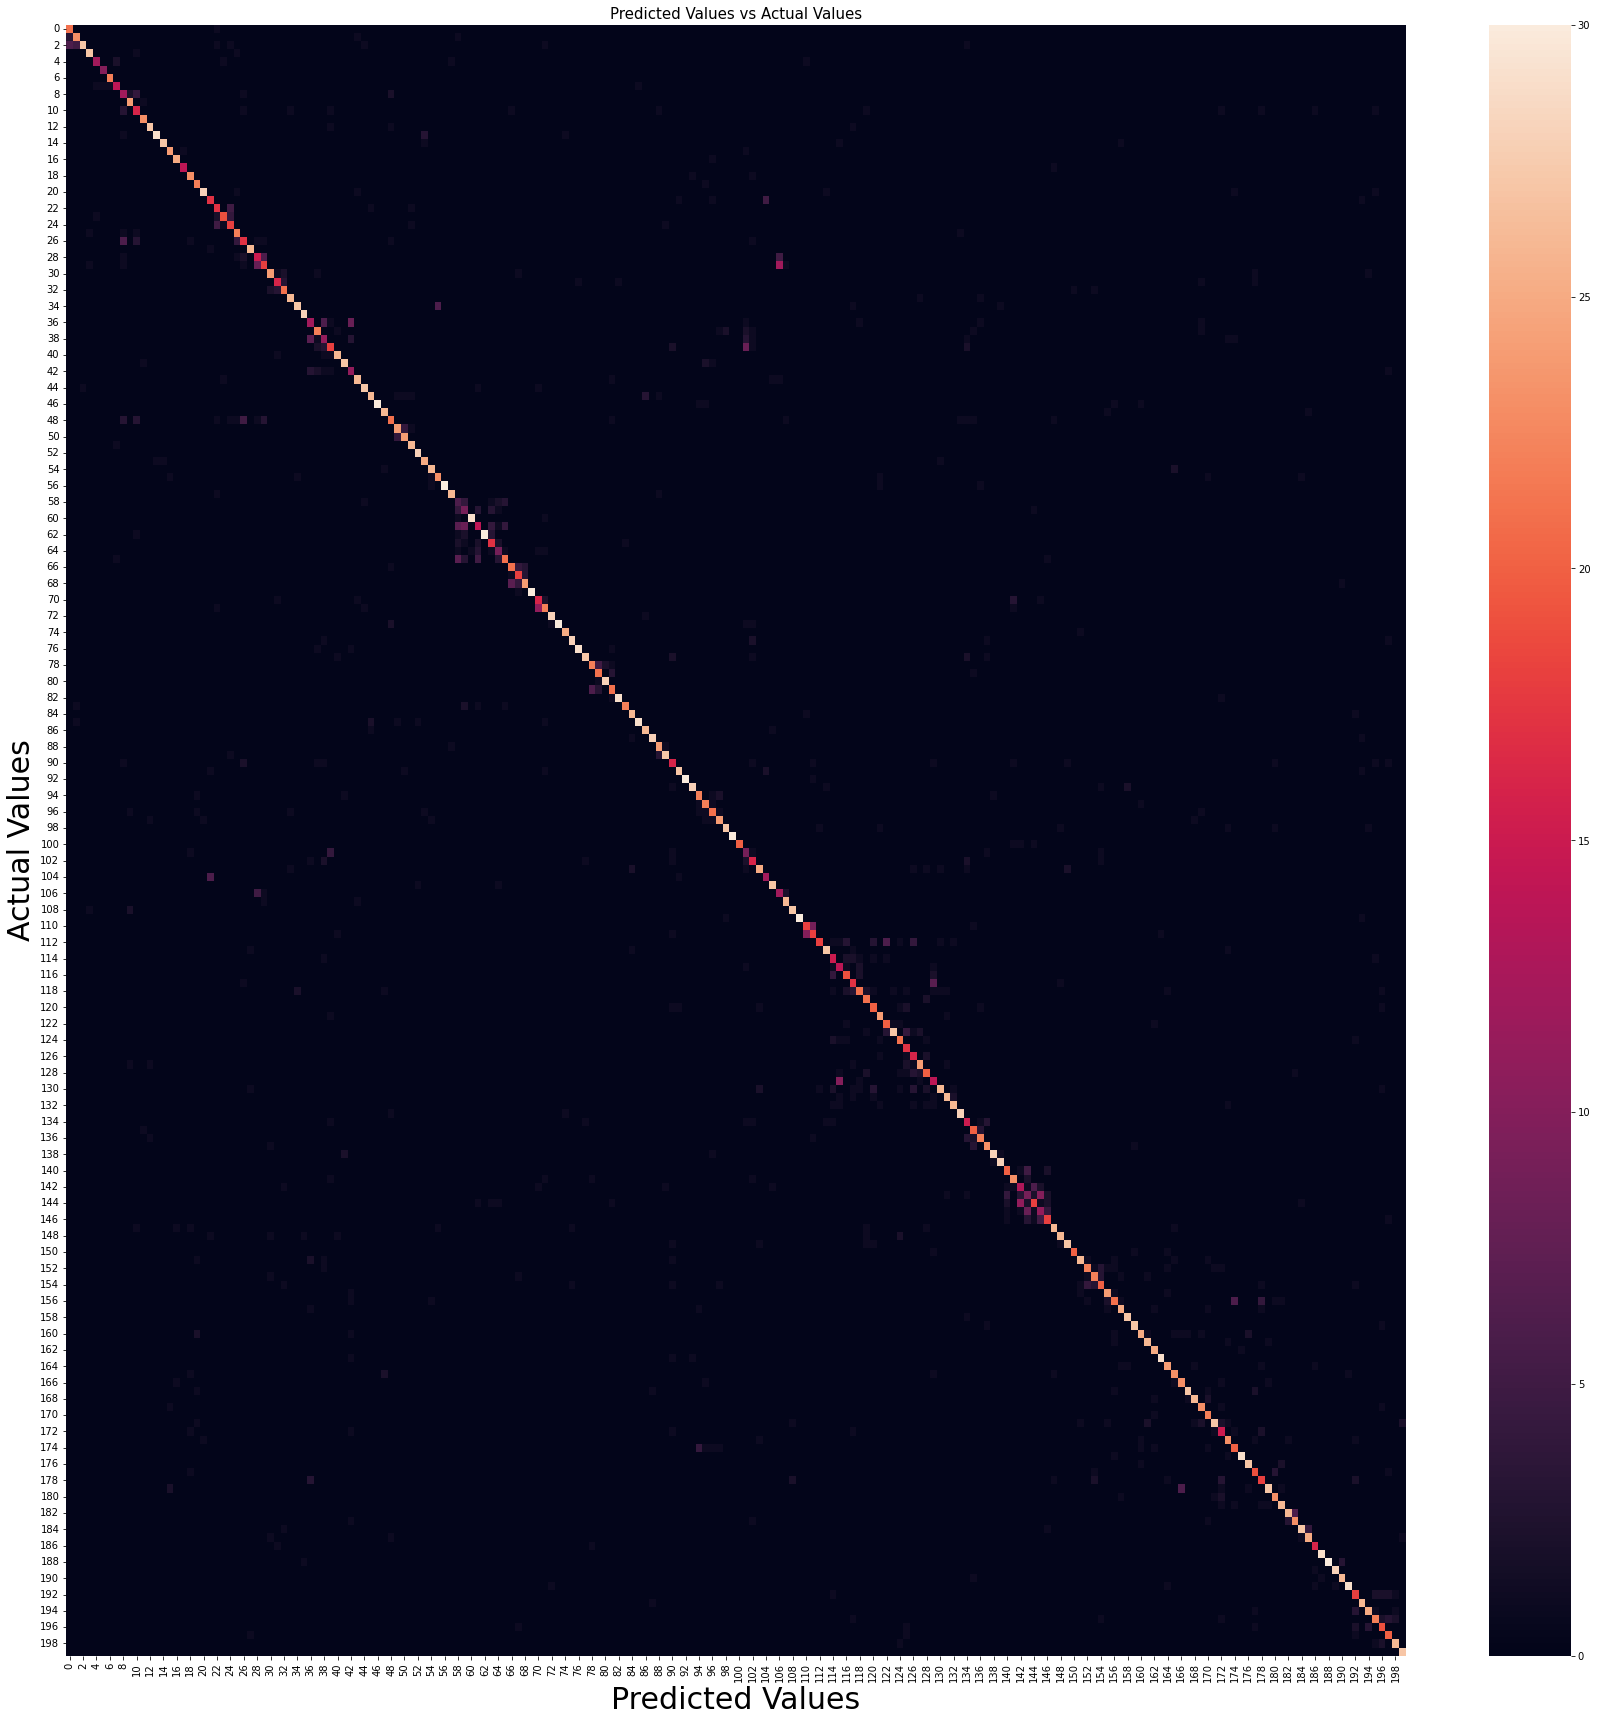

In [ ]:
pred = np.argmax(xceptionModel.predict(test_datagen), axis = -1)
classes = test_datagen.classes

conf = confusion_matrix(pred, classes) # Confusion Matrix
# Plotting Confusion Matrix Heat Map
plt.figure(figsize = (30,30)) 
sns.heatmap(conf, fmt='')
plt.xlabel('Predicted Values', fontsize = 30)
plt.ylabel('Actual Values', fontsize =30)
plt.title('Predicted Values vs Actual Values', fontsize = 15)

In [ ]:
print('Classification Report')
print(classification_report(test_datagen.classes, pred, target_names=test_datagen.classes))

# Load Xception Model

load test images using path from a dataframe with columns **'image_path' (199.Winter_Wren/Winter_Wren_0077_190366.jpg)** and **'class_name' (199.Winter_Wren)**

In [ ]:
test_ds = image_metadata.loc[image_metadata['is_train'] == False]

test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = (test_datagen.flow_from_dataframe(
                  dataframe=test_ds,
                  directory='/content/CUB_200_2011/images/',
                  x_col='image_path',
                  y_col='class_name',
                  batch_size=batch_size,
                  seed=42,
                  shuffle=False,
                  class_mode='categorical',
                  color_mode='rgb',
                  target_size=orig_img_size) )

replace the path with the trained model path and execute the cells that follow

In [46]:
final_model = keras.models.load_model('/content/drive/MyDrive/deep_learning/XceptionModelFinal/xception_ft-saved-model-28-val_acc-0.77')

In [47]:
test_score = final_model.evaluate_generator(test_datagen, 32)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

<ipython-input-47-1efa32abb99e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_score = final_model.evaluate_generator(test_datagen, 32)


[INFO] accuracy: 75.88%
[INFO] Loss:  0.8920853734016418


In [48]:
pred = np.argmax(final_model.predict(test_datagen), axis = -1)
classes_list = test_datagen.classes

182/182 [==============================] - 52s 283ms/step


Text(0.5, 1.0, 'Predicted Values vs Actual Values')

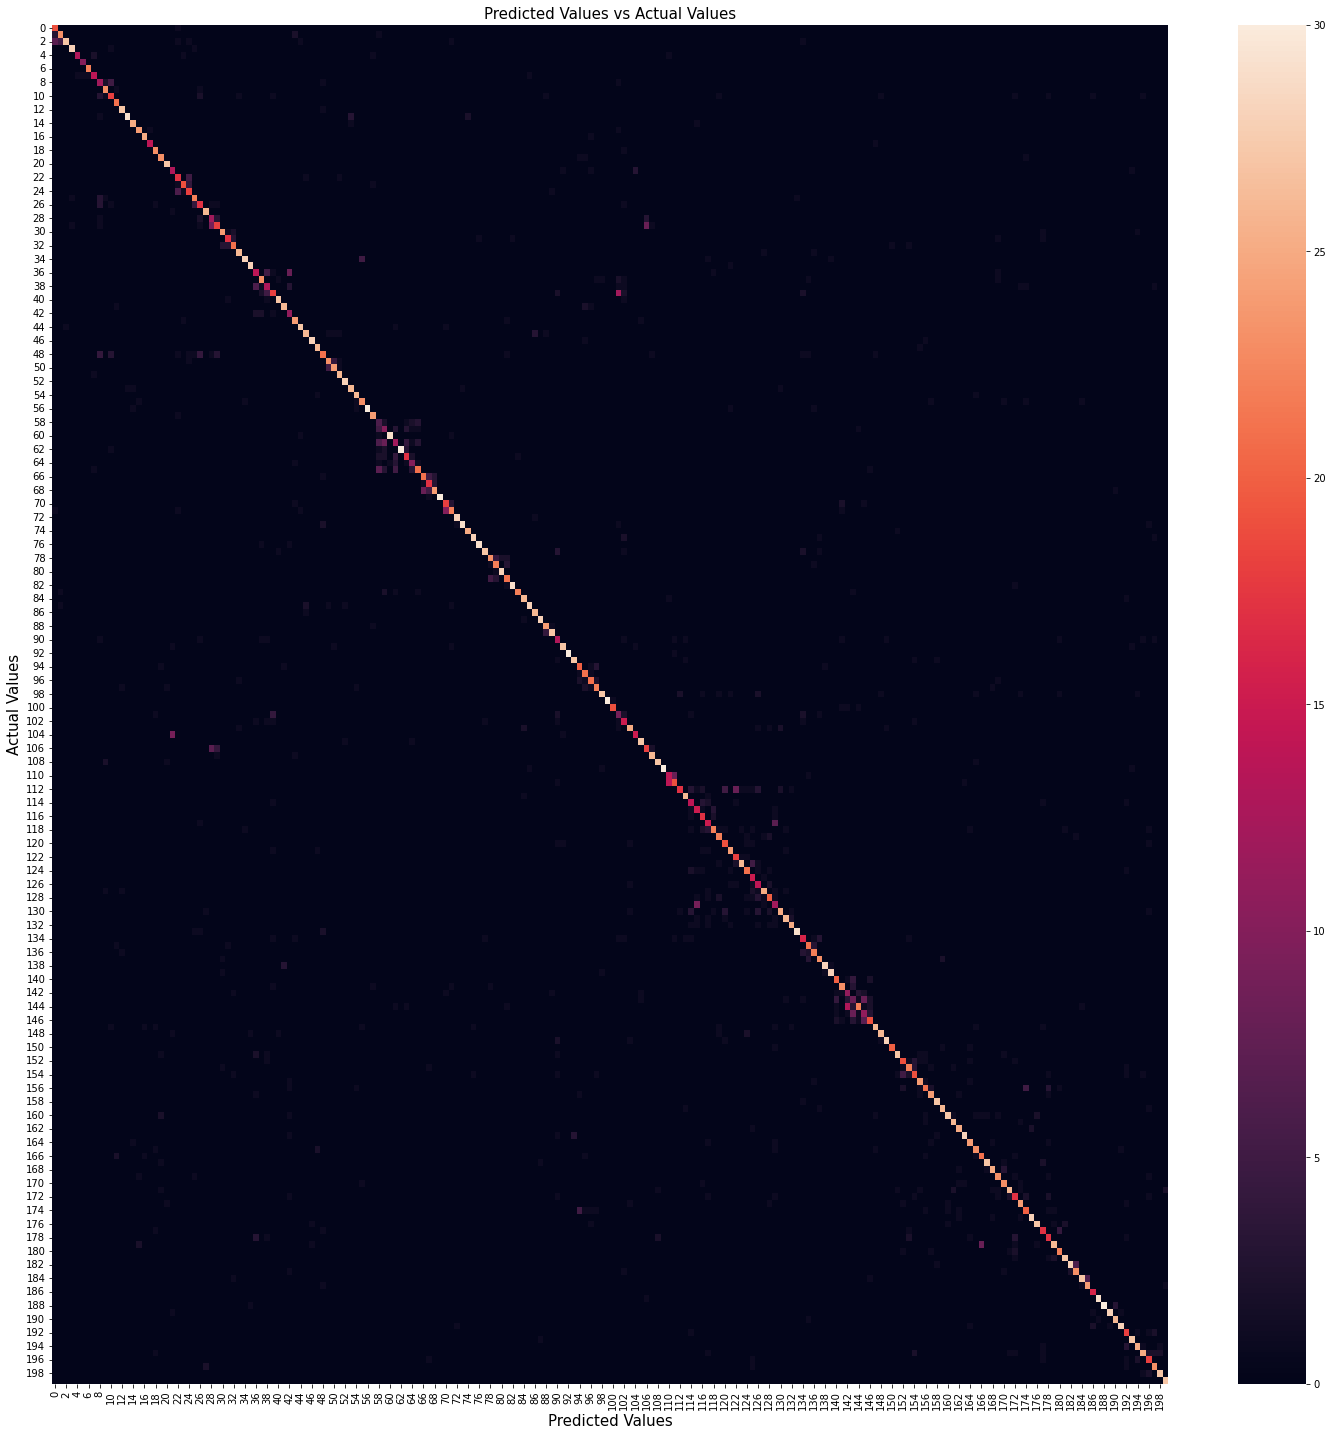

In [45]:

conf = confusion_matrix(pred, classes_list) # Confusion Matrix
import seaborn as sns
# Plotting Confusion Matrix Heat Map
plt.figure(figsize = (25,25)) 
sns.heatmap(conf, fmt='')
plt.xlabel('Predicted Values', fontsize = 15)
plt.ylabel('Actual Values', fontsize =15)
plt.title('Predicted Values vs Actual Values', fontsize = 15)

In [39]:
print('Classification Report')
print(classification_report(test_datagen.classes, pred))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.63      0.76        30
           1       0.79      0.77      0.78        30
           2       0.61      0.96      0.75        28
           3       0.93      0.93      0.93        30
           4       0.72      0.93      0.81        14
           5       1.00      0.91      0.95        11
           6       1.00      0.96      0.98        23
           7       0.78      0.78      0.78        18
           8       0.57      0.41      0.48        29
           9       0.92      0.77      0.84        30
          10       0.55      0.60      0.57        30
          11       1.00      0.81      0.89        26
          12       0.96      0.90      0.93        30
          13       0.83      0.97      0.89        30
          14       0.93      0.89      0.91        28
          15       0.92      0.86      0.89        28
          16       0.96      0.93      0.94        27
     

In [41]:
df = pd.DataFrame(classification_report(test_datagen.classes, pred,output_dict=True)).transpose() # target_names=classes_list

In [44]:
df.to_csv('classification_report.csv', index = False)